In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.decomposition import PCA
from matplotlib.offsetbox import AnchoredText
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
# load data
full_data = pd.read_csv("/home/lima/Projects/simulation/SingleSample/countsMatrixWithCutOff 0 .csv")
quaterCut = pd.read_csv("/home/lima/Projects/simulation/SingleSample/countsMatrixWithCutOff 2.5 .csv")
halfCut = pd.read_csv("/home/lima/Projects/simulation/SingleSample/countsMatrixWithCutOff 5 .csv")
threeQtrCut = pd.read_csv("/home/lima/Projects/simulation/SingleSample/countsMatrixWithCutOff 7.5 .csv")
tenCut = pd.read_csv("/home/lima/Projects/simulation/SingleSample/countsMatrixWithCutOff 10 .csv")

In [4]:
# plot violin and box plot
full_data = full_data.rename(columns = {"Unnamed: 0": "GeneID"})
quaterCut = quaterCut.rename(columns = {"Unnamed: 0": "GeneID"})
halfCut = halfCut.rename(columns = {"Unnamed: 0": "GeneID"})
threeQtrCut = threeQtrCut.rename(columns = {"Unnamed: 0": "GeneID"})
tenCut = tenCut.rename(columns = {"Unnamed: 0": "GeneID"})

In [56]:
def scatterPlot(df, ax):
    
    notInRealData = df.index[df.iloc[ : , 0] == 0].tolist()
    notInSimulatedData = df.index[df.iloc[ : , 1] == 0].tolist()
    inNeither = list(set(notInRealData) & set(notInSimulatedData))
    df["ExpressionStatus"] = ["BothSamples"] * len(df)
    df.loc[notInRealData, "ExpressionStatus"] = "SimulatedOnly"
    df.loc[notInSimulatedData, "ExpressionStatus"] = "RealOnly"
    df.loc[inNeither, "ExpressionStatus"] = "NeithSample"
    sns.set(style="white", palette="muted", color_codes=True)
    
    sns.scatterplot(x = 'PDX_14P3_20_real', y = 'PDX_14P3_20_sim', hue = 'ExpressionStatus', data = df, ax = ax)
    #axes.set_xlabel("Distribution for real data and simulated data")
    at = AnchoredText("{neither} not expressed in neither sample\n {realOnly} found in real data only\n {simOnly} found in simulated data only".format(
        neither = len(inNeither), realOnly = len(notInSimulatedData) - len(inNeither), simOnly = len(notInRealData) - len(inNeither)),
                  prop = dict(size = 30), frameon = True,
                  loc = 'upper left'
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_xlabel("Simulated Data")
    ax.set_ylabel("Real Data")
    ax.set_title("Scatted plot for the correlation between real data and simulated data")
    ax.legend(loc = 'lower right', fancybox = True, shadow = False, scatterpoints = 200, prop = {'size': 30})
    #print(df.loc[inNeither])
    #print(notInRealData)
    #print(notInSimulatedData)

In [57]:
# function corrScatterPlot is a helper function for scatter-plotting the correlation between two sets of data with 
# different colors. 
def corrScatterPlot(df, ax):
    """
    Input:
    @df: a pandas dataframe object which provides the data for plotting
    @ax: an axes object on which the plot is going to be plotted
    
    Output:
    an axes object
    """
    df = np.log2(df[['PDX_14P3_20_real', 'PDX_14P3_20_sim']] + 1)
    pca = PCA(n_components = 2)
    pca.fit(df)
    
    # take out the explained_variance_ for finding the one keeps the most variability
    variances = pca.explained_variance_
    
    # index records the index of the desired variances
    index = 0 if (variances[0] > variances[1]) else 1
    
    pcs = pca.transform(df)
    
    # take the variances
    pc = pcs[ : , index]
    
    # find the minimum components
    min_pc = np.amin(pc)

    # check if it is negative, make it non-negative and add it to pc
    if min_pc < 0:
        min_pc = np.abs(min_pc)
        pc = pc + min_pc
        
    #calculate the correlation between the two sets of data.
    corr = scipy.stats.pearsonr(df.iloc[ : , 0], df.iloc[ : , 1])[0]   
    plt.style.use('seaborn-whitegrid')
    ax.scatter(pc, df.iloc[ : , 0], s = 20, c = 'b', alpha = 0.05, marker = "s", label = 'Real')
    ax.scatter(pc, df.iloc[ : , 1], s = 20, c = 'r', alpha = 0.05, marker = "o", label = 'Simulated')
    
    at = AnchoredText("Corr: {corr}".format(corr = corr),
                  prop = dict(size = 40), frameon = True,
                  loc = 'upper left'
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_xlabel("Simulated Data")
    ax.set_ylabel("Real Data")
    ax.set_title("Scatted plot for the correlation between real data and simulated data")
    ax.legend(loc = 'center left', fancybox = True, shadow = False, scatterpoints = 200, prop = {'size': 40});
    

In [58]:
def buildPlotBlock(df, axes):
    """
    buildPlotBlock is a helper function helping putting the desired plots, such as the scatter plot, box plot,
    violin plot and the distribution plot into a grided pyplot
    
    Input:
    @df: the dataframe which provides the data
    @axes: a 2x2 subplot matrix 
    """
    df = np.log2(df[['PDX_14P3_20_real', 'PDX_14P3_20_sim']] + 1)
    sns.set(style="white", palette="muted", color_codes=True)
    # put the violin plot to axes[0, 0]
    sns.violinplot(data = df, linewidth = 0.8, palette = "husl", ax = axes[0, 0])
    
    # put the boxplot to axes[1, 1]
    sns.boxplot(data = df, linewidth = 0.8, palette = "husl", ax = axes[1, 1])
    
    # put the distribution plot to axes[0, 1]
    sns.distplot(df.iloc[ : , 0], kde = True, color = "b", label = 'Real', ax = axes[0, 1])
    sns.distplot(df.iloc[ : , 1], kde = True, color = "r", label = 'Simulated', ax = axes[0, 1])
    axes[0, 1].legend(loc = 'center right', prop = {'size': 40})
    axes[0, 1].set_xlabel("Distribution plot for real data and simulated data")
    
    # put the scatter plot to axes [1, 0]
    scatterPlot(df, axes[1, 0])
    

[]

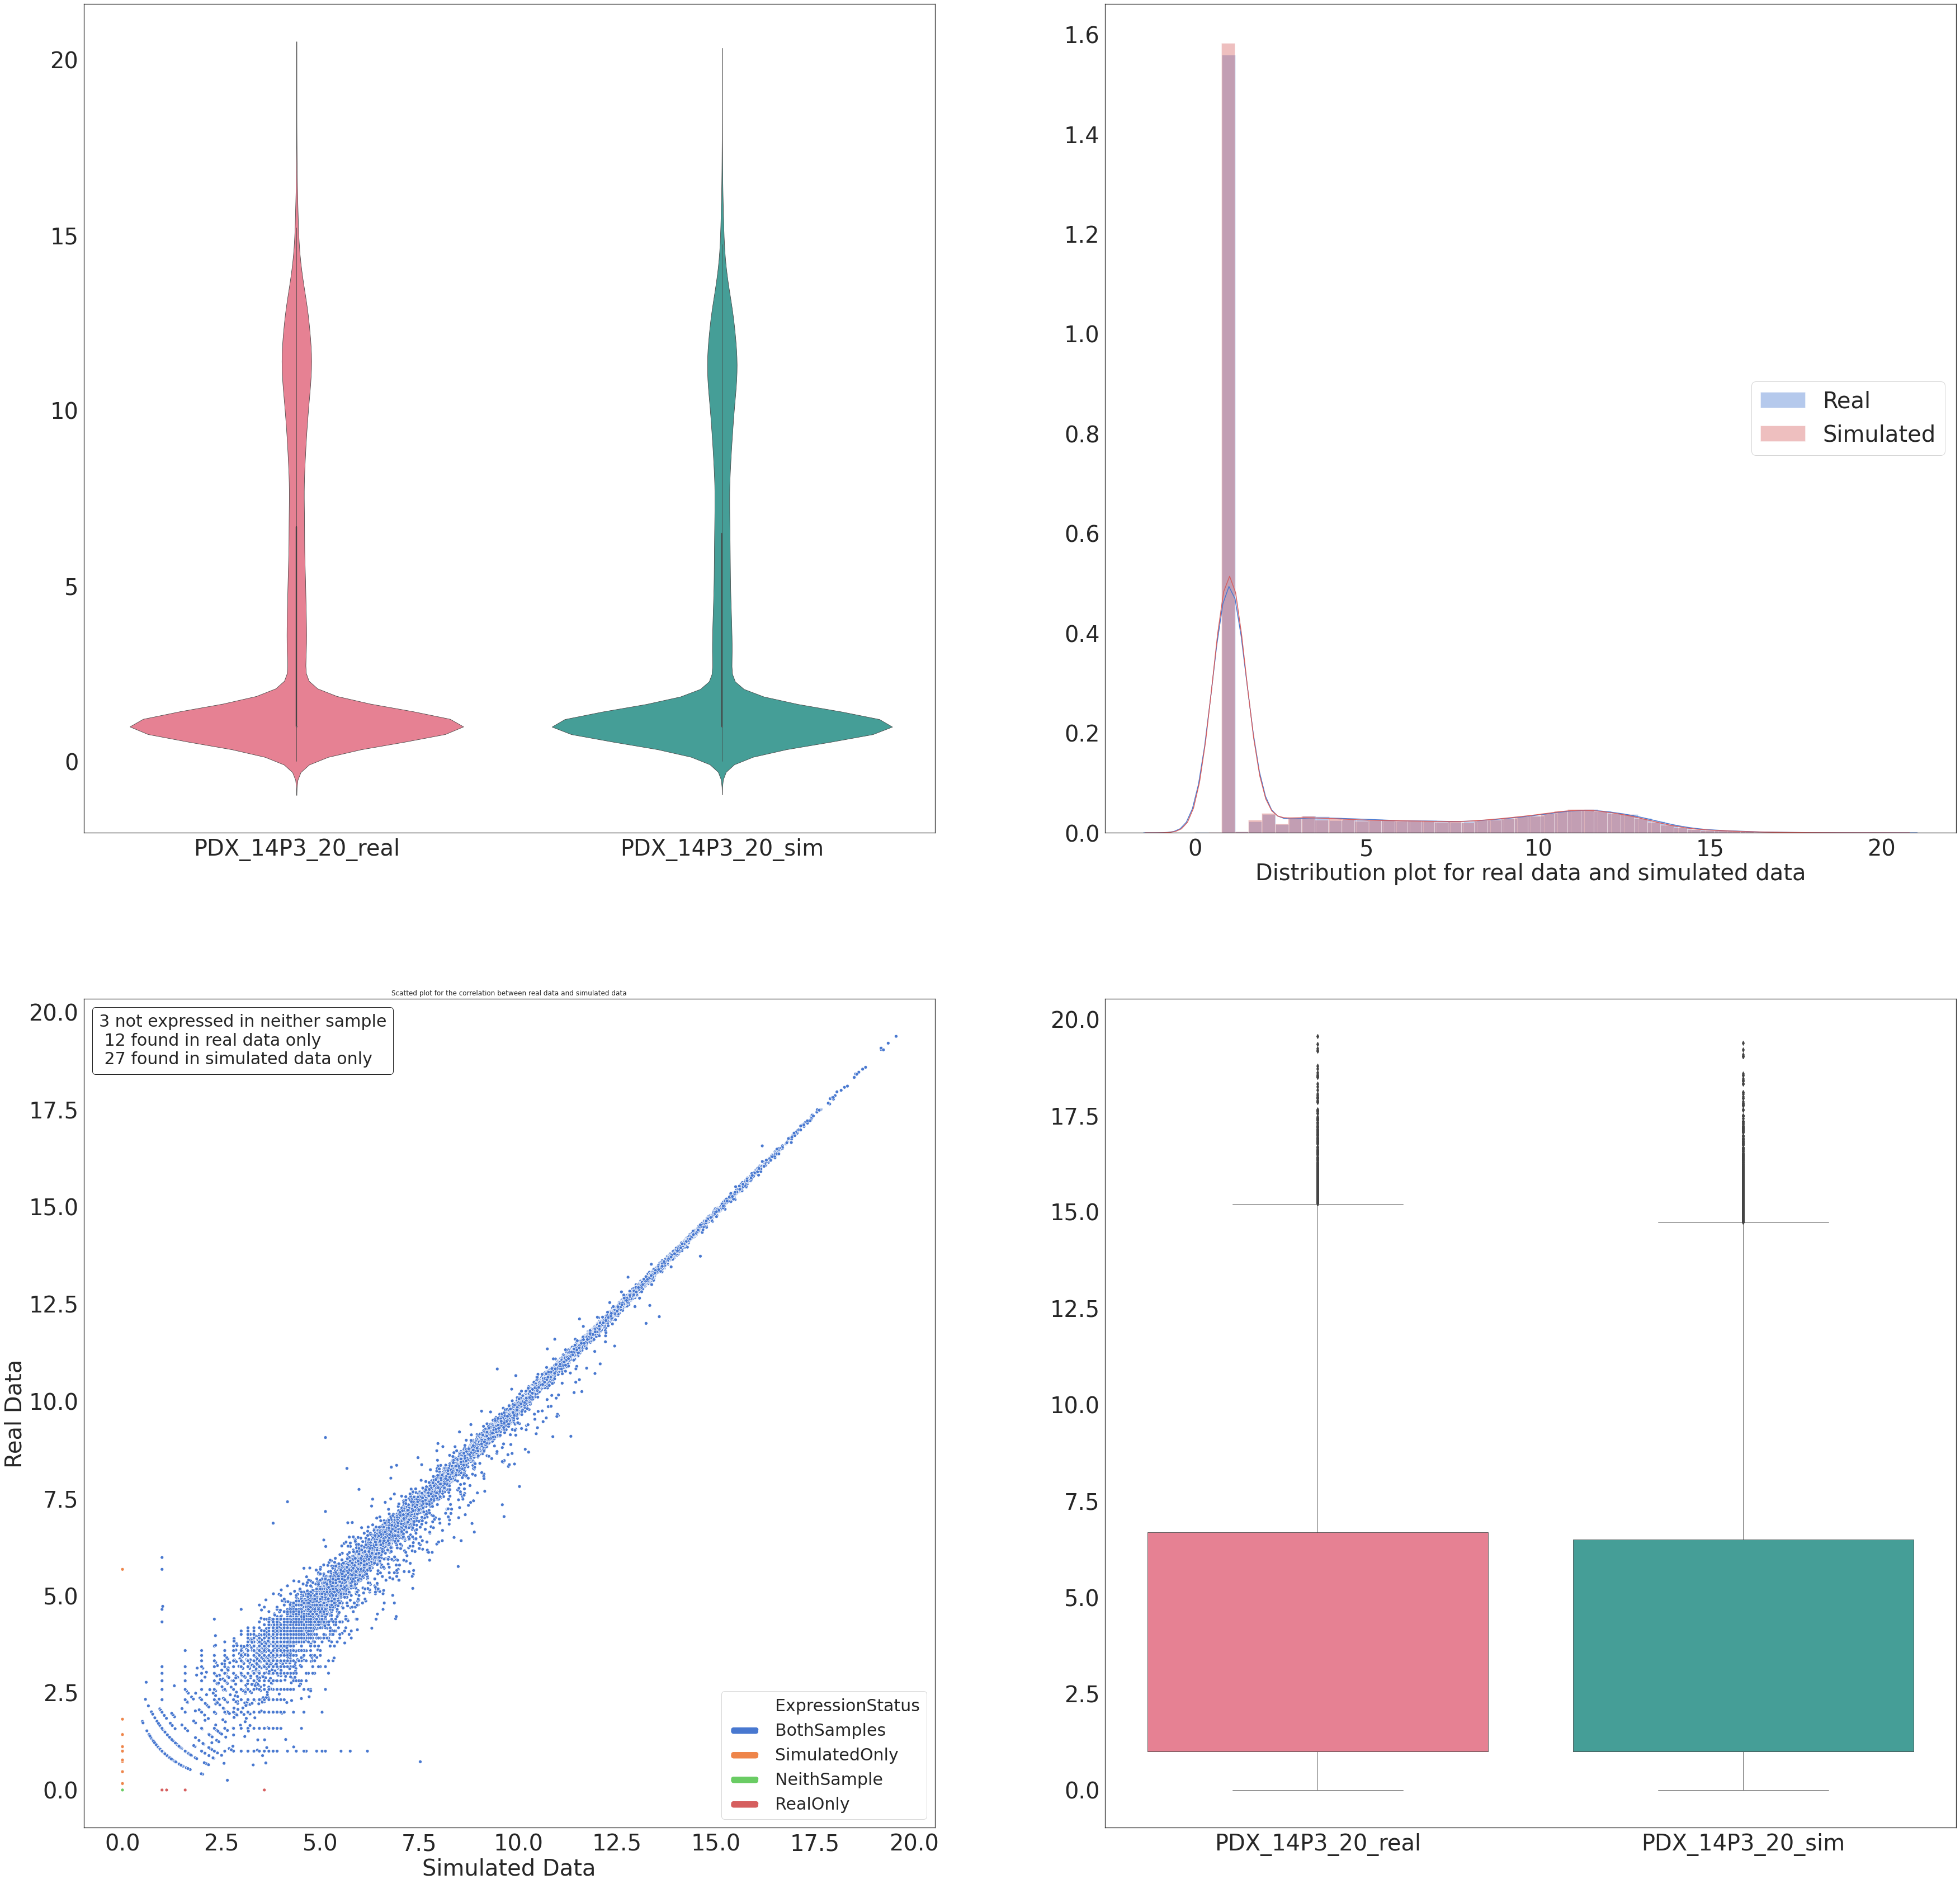

In [59]:
params = {'legend.fontsize': 40,
          'figure.figsize': (60, 60),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'xtick.labelsize': 40,
         'ytick.labelsize': 40}
pylab.rcParams.update(params)
f, axes = plt.subplots(2, 2)
buildPlotBlock(full_data, axes)
plt.plot()

[]

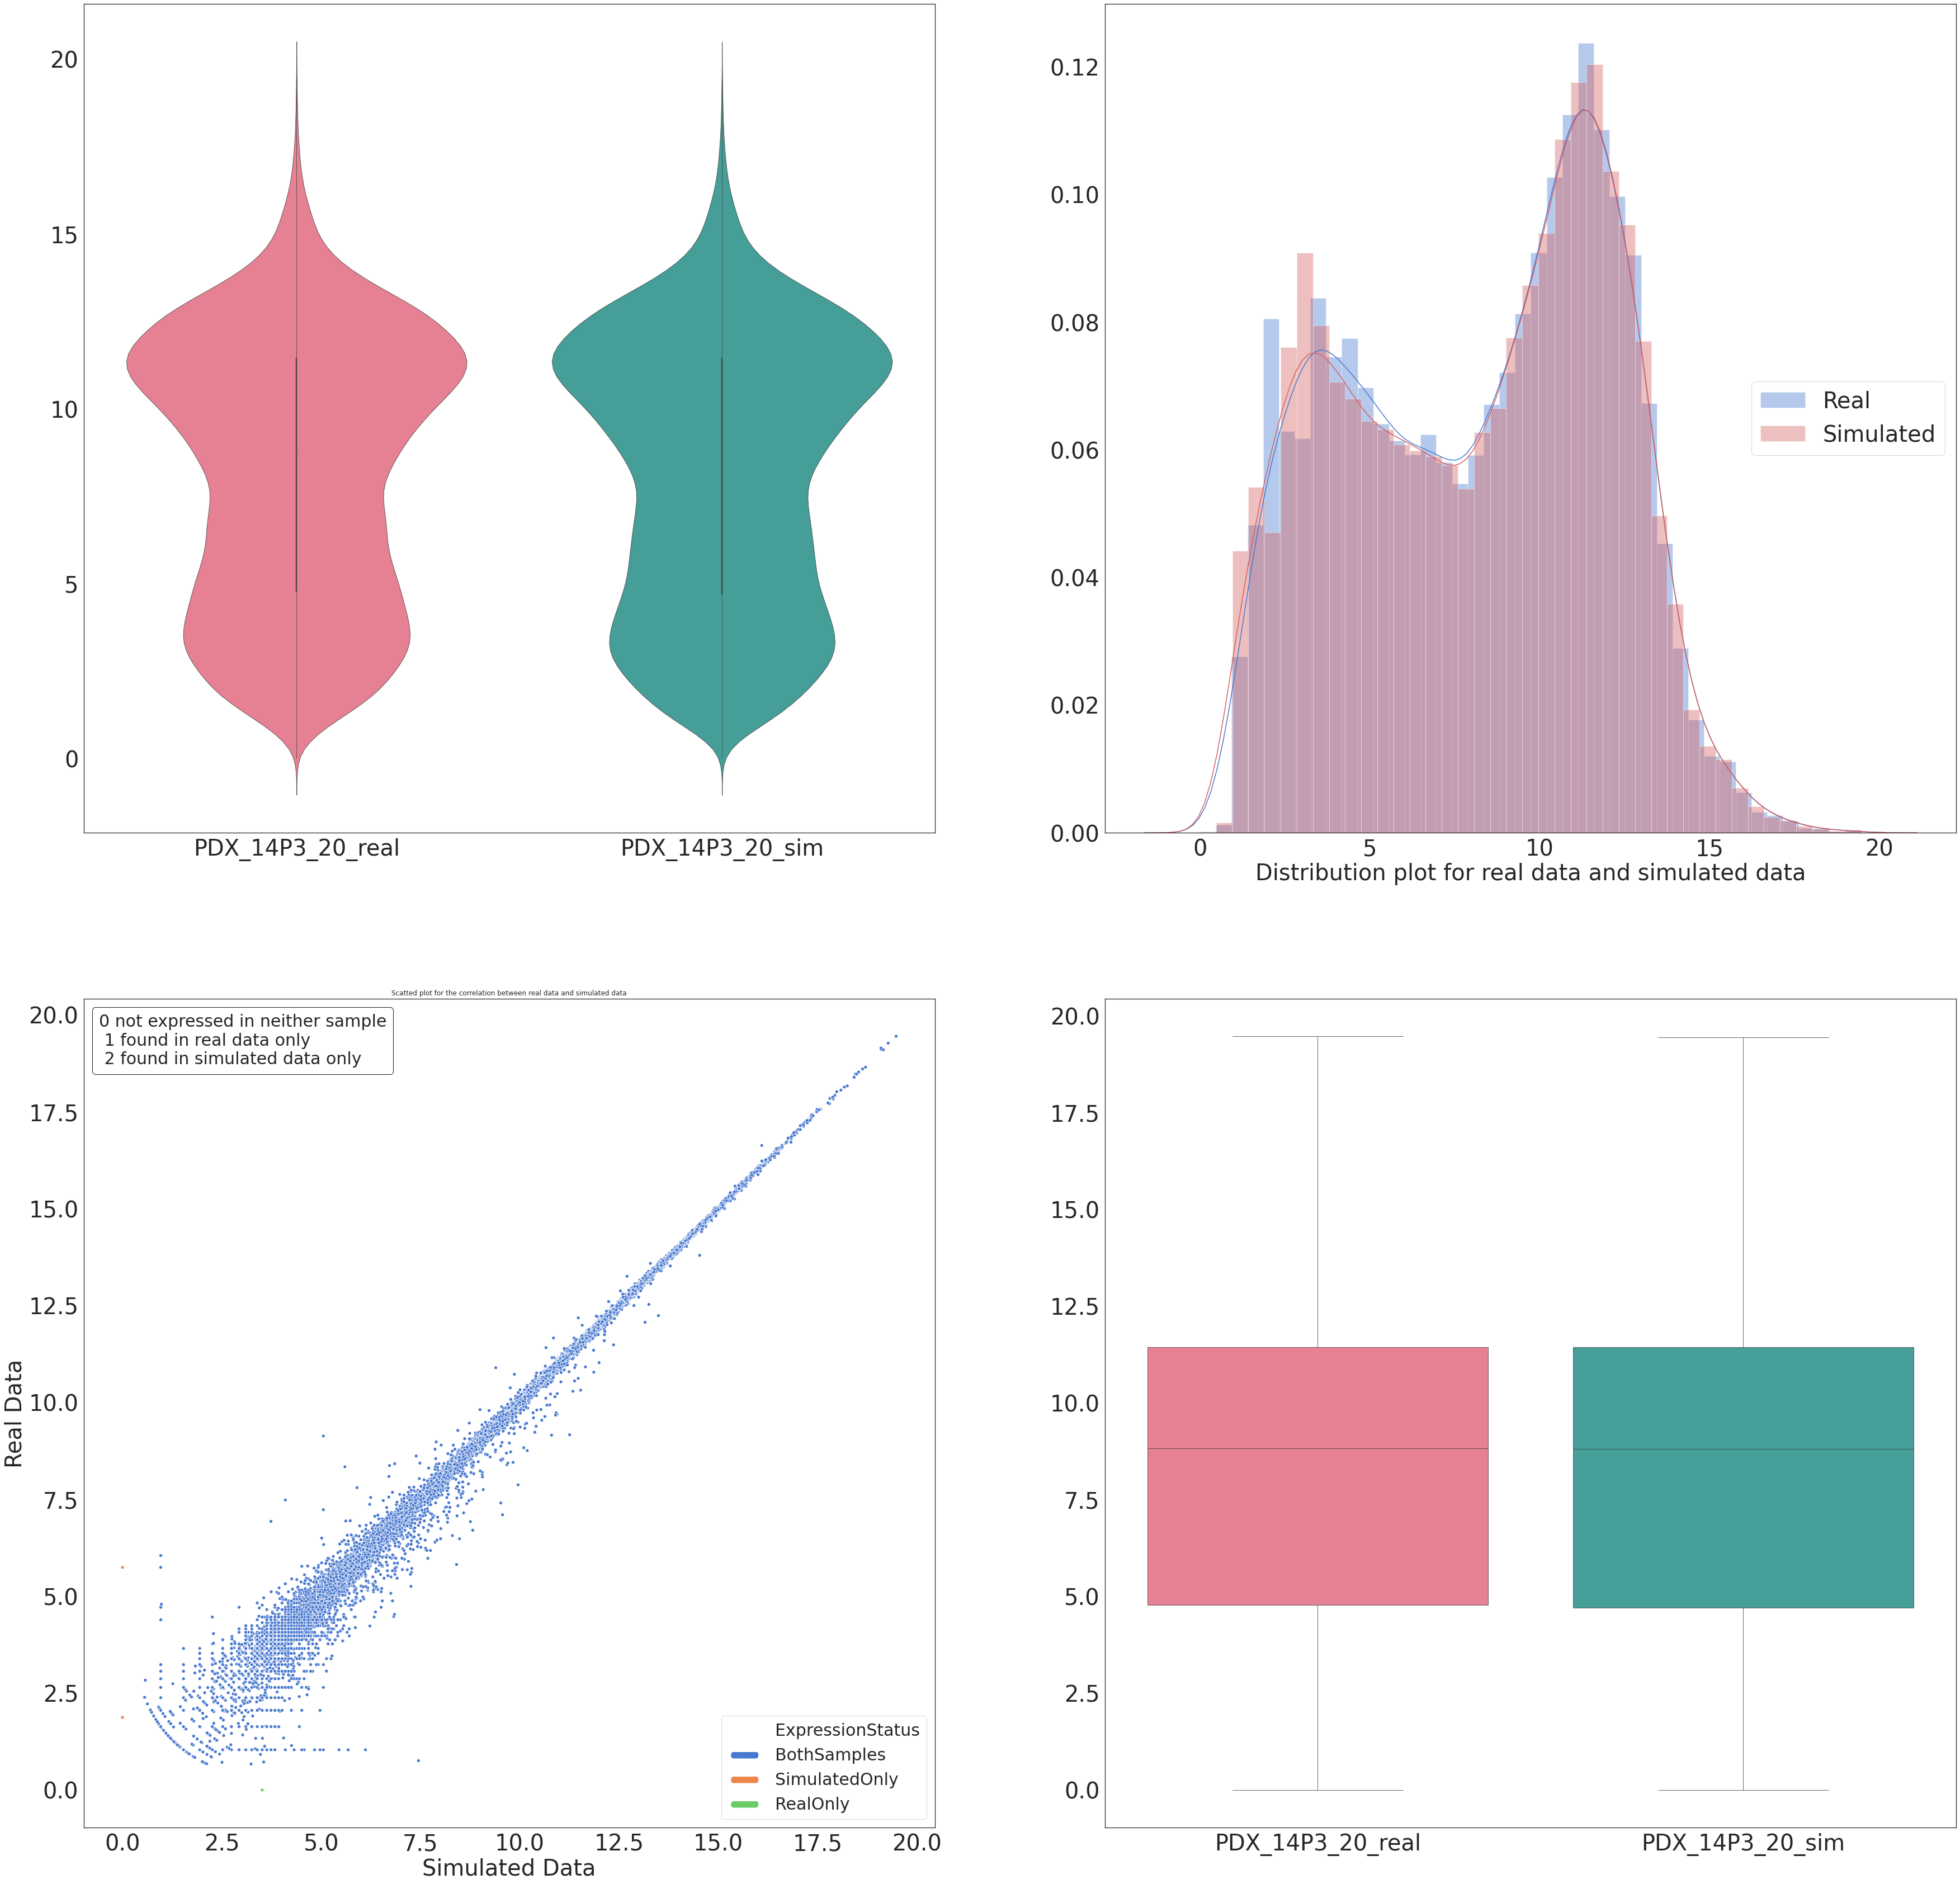

In [60]:
params = {'legend.fontsize': 40,
          'figure.figsize': (60, 60),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'xtick.labelsize': 40,
         'ytick.labelsize': 40}
pylab.rcParams.update(params)
f, axes = plt.subplots(2, 2, figsize = (60, 60))
buildPlotBlock(quaterCut, axes)
plt.plot()

[]

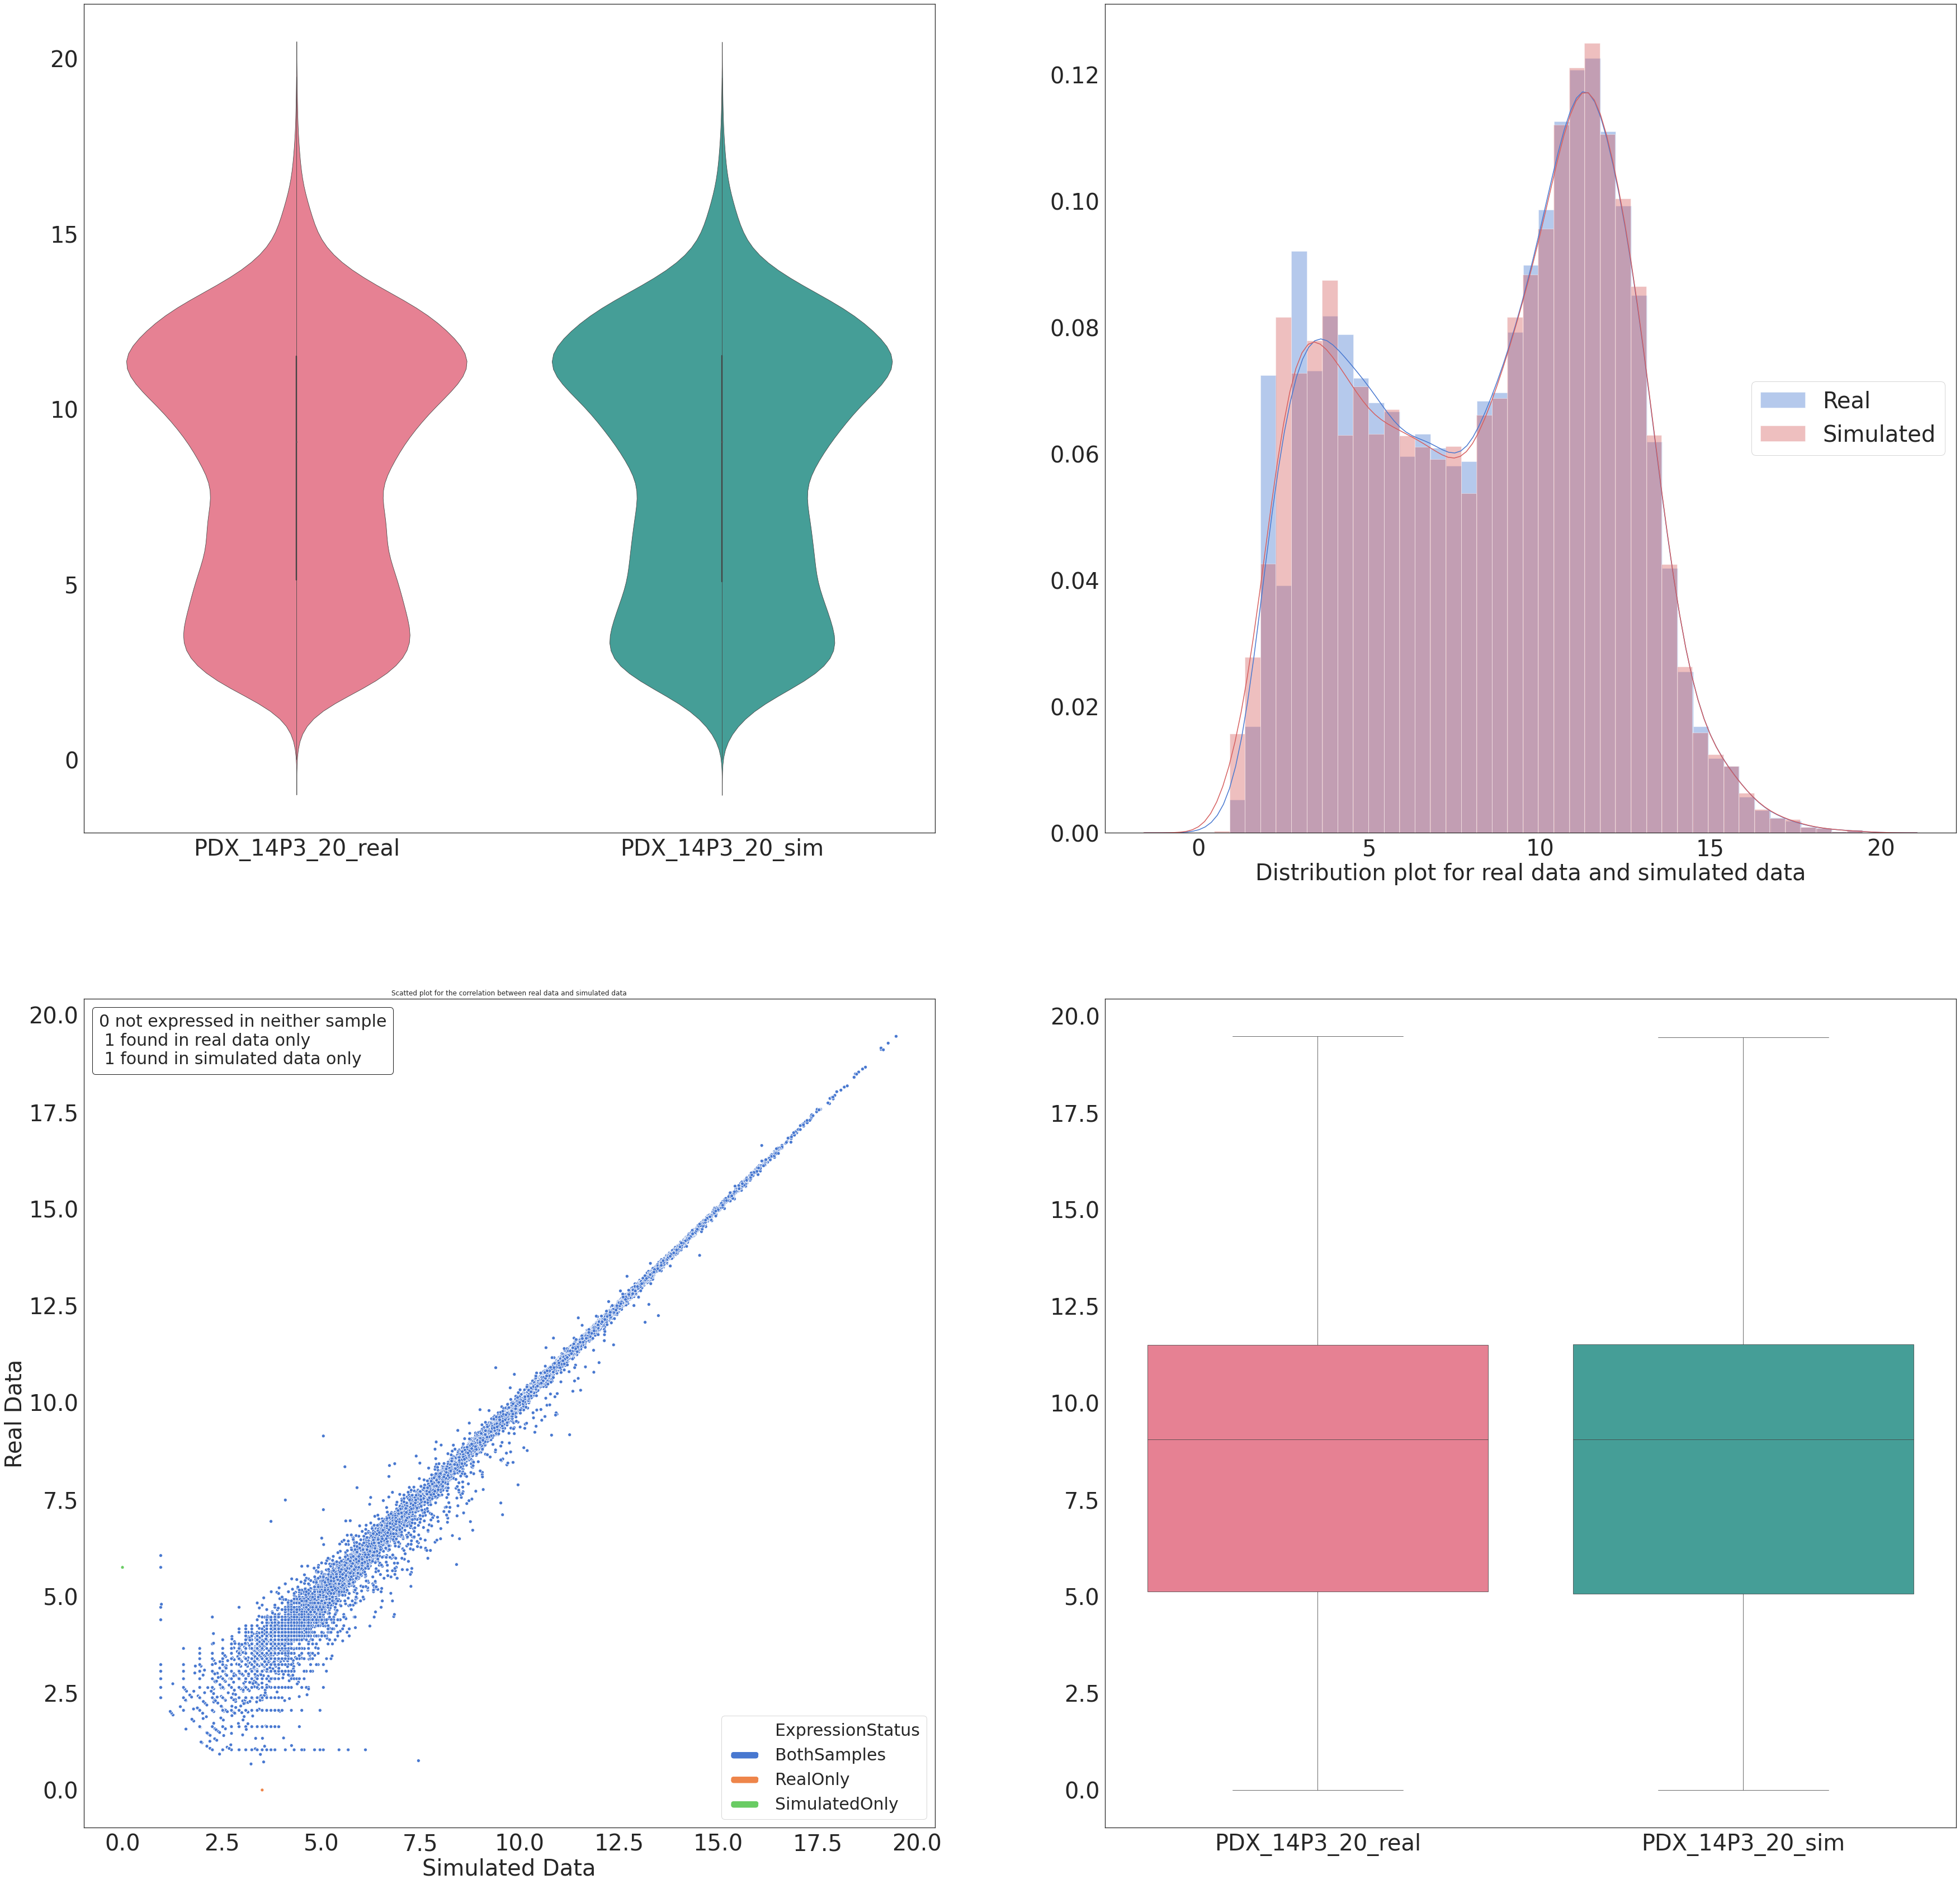

In [61]:
params = {'legend.fontsize': 40,
          'figure.figsize': (60, 60),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'xtick.labelsize': 40,
         'ytick.labelsize': 40}
pylab.rcParams.update(params), 
f, axes = plt.subplots(2, 2, figsize = (60, 60))
buildPlotBlock(halfCut, axes)
plt.plot()

[]

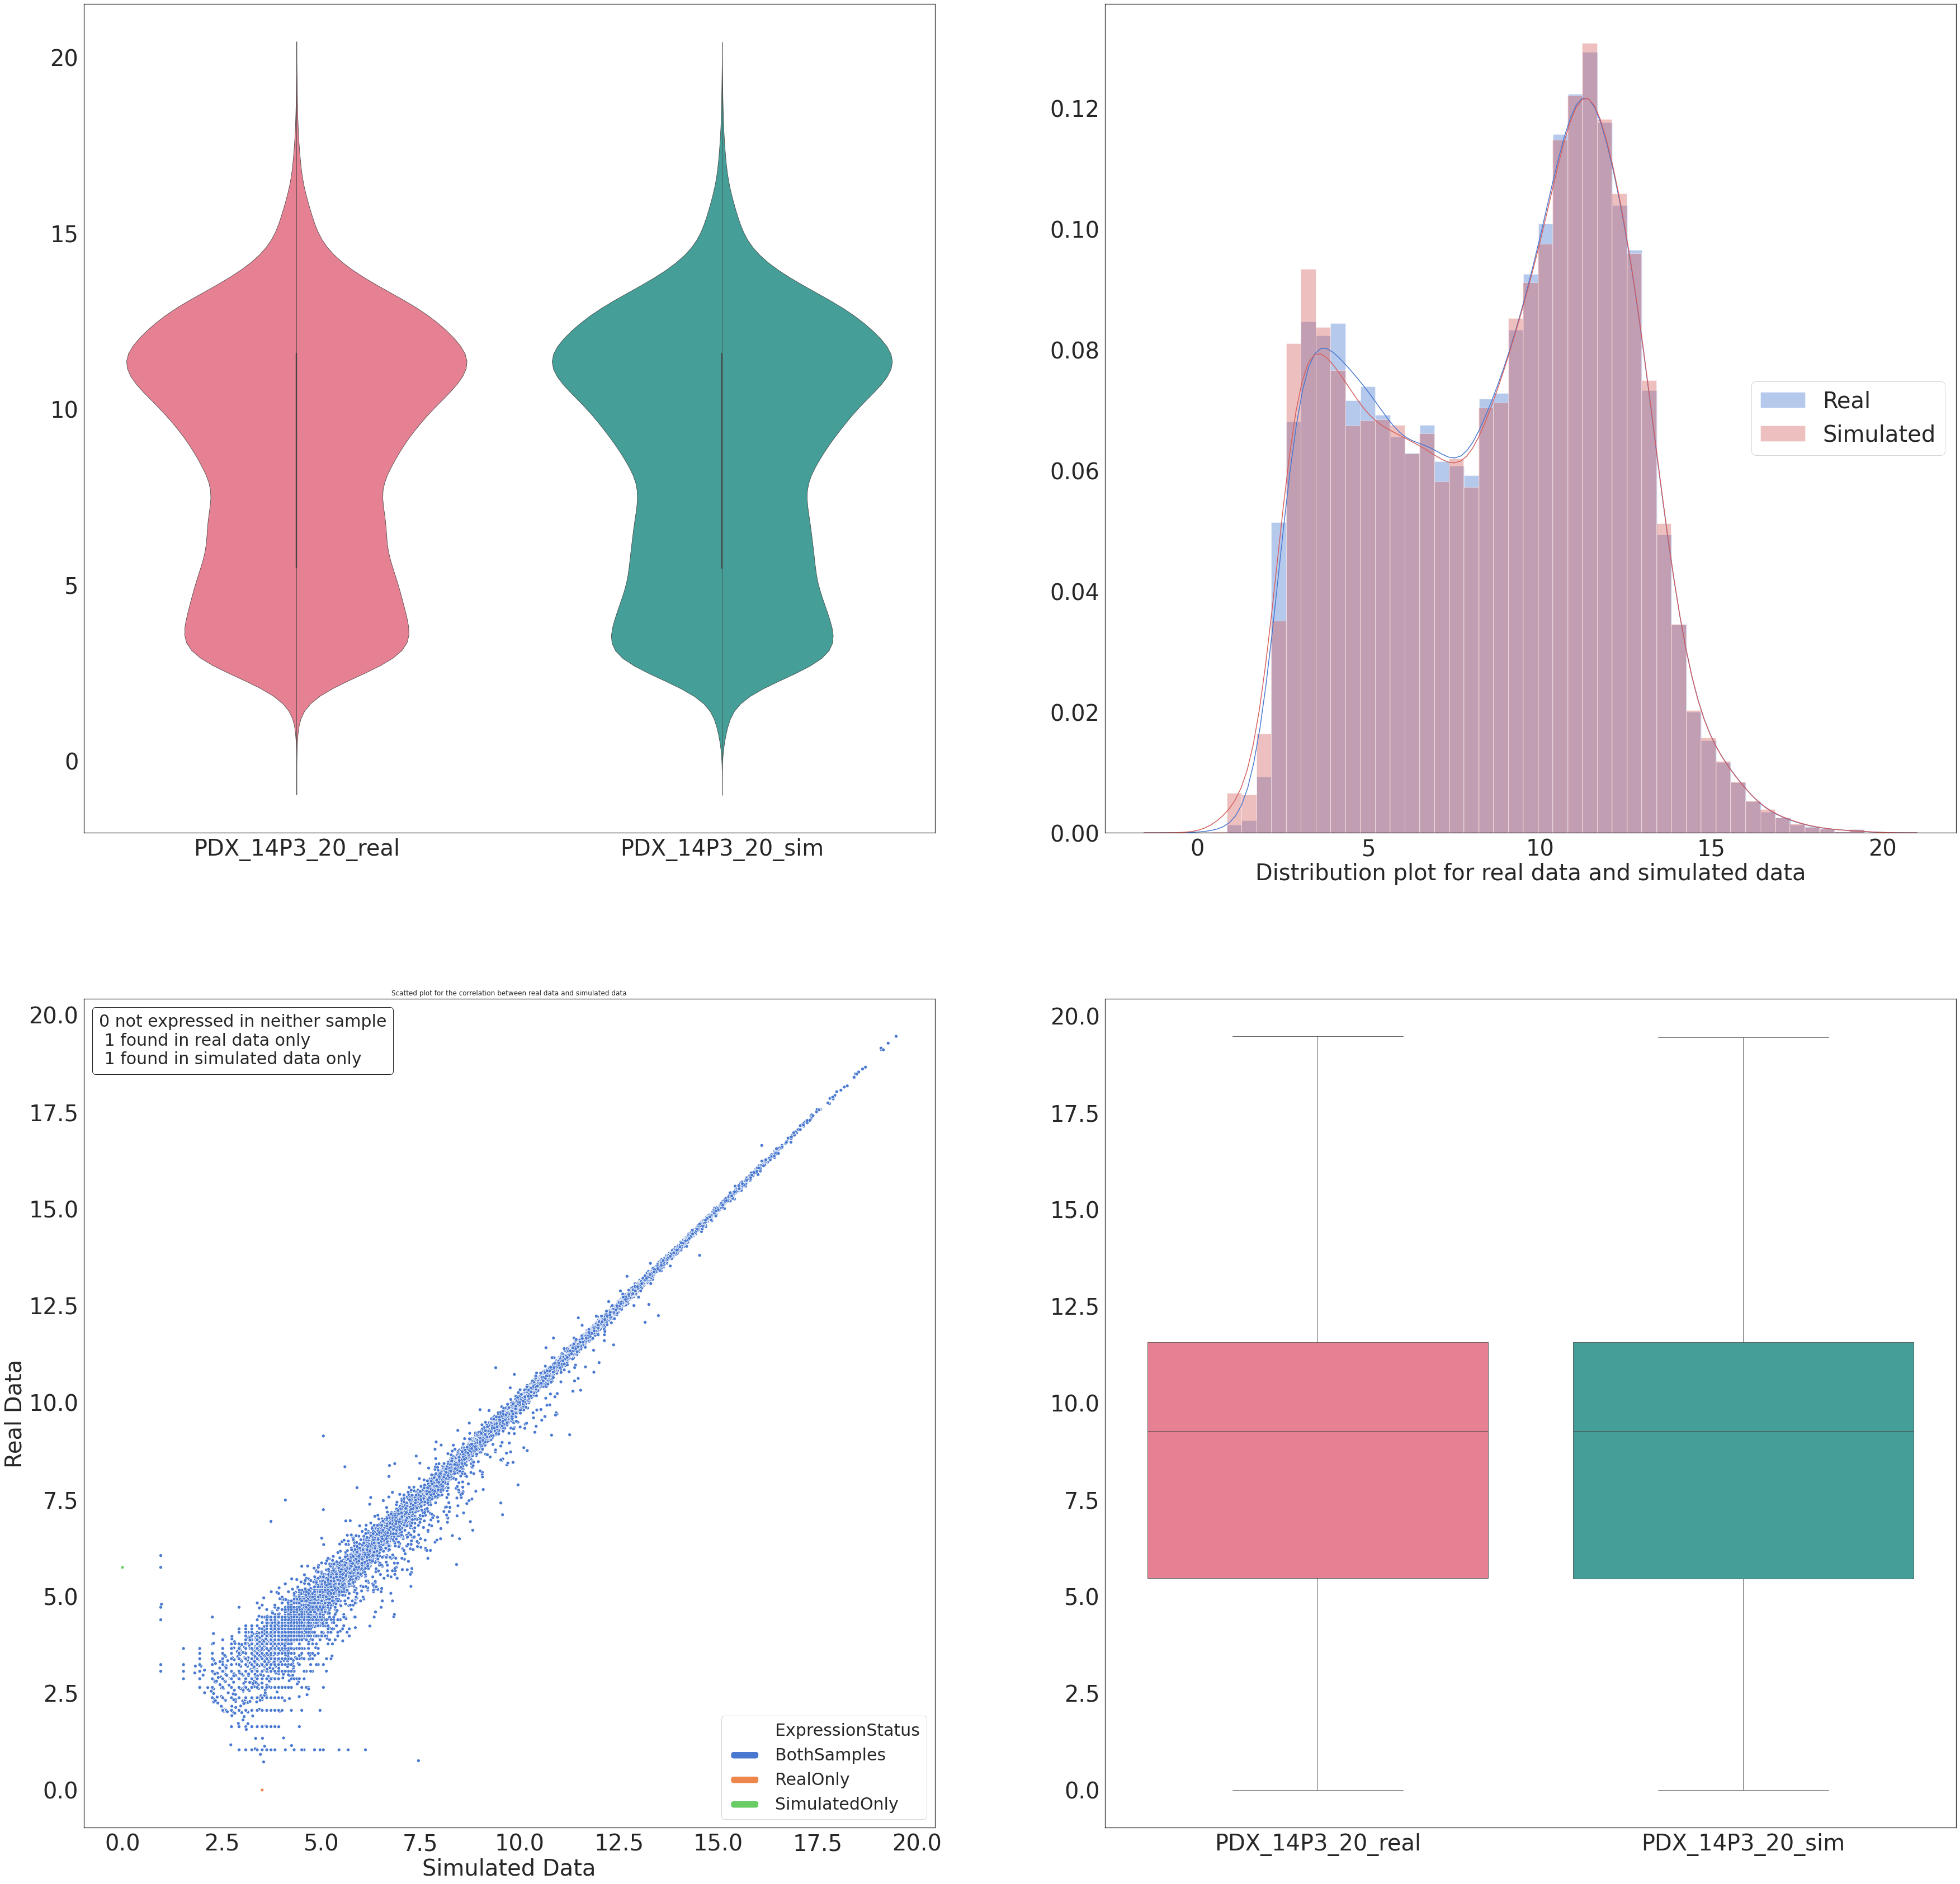

In [62]:
params = {'legend.fontsize': 40,
          'figure.figsize': (60, 60),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'xtick.labelsize': 40,
         'ytick.labelsize': 40}
pylab.rcParams.update(params)
f, axes = plt.subplots(2, 2, figsize = (60, 60))
buildPlotBlock(threeQtrCut, axes)
plt.plot()

[]

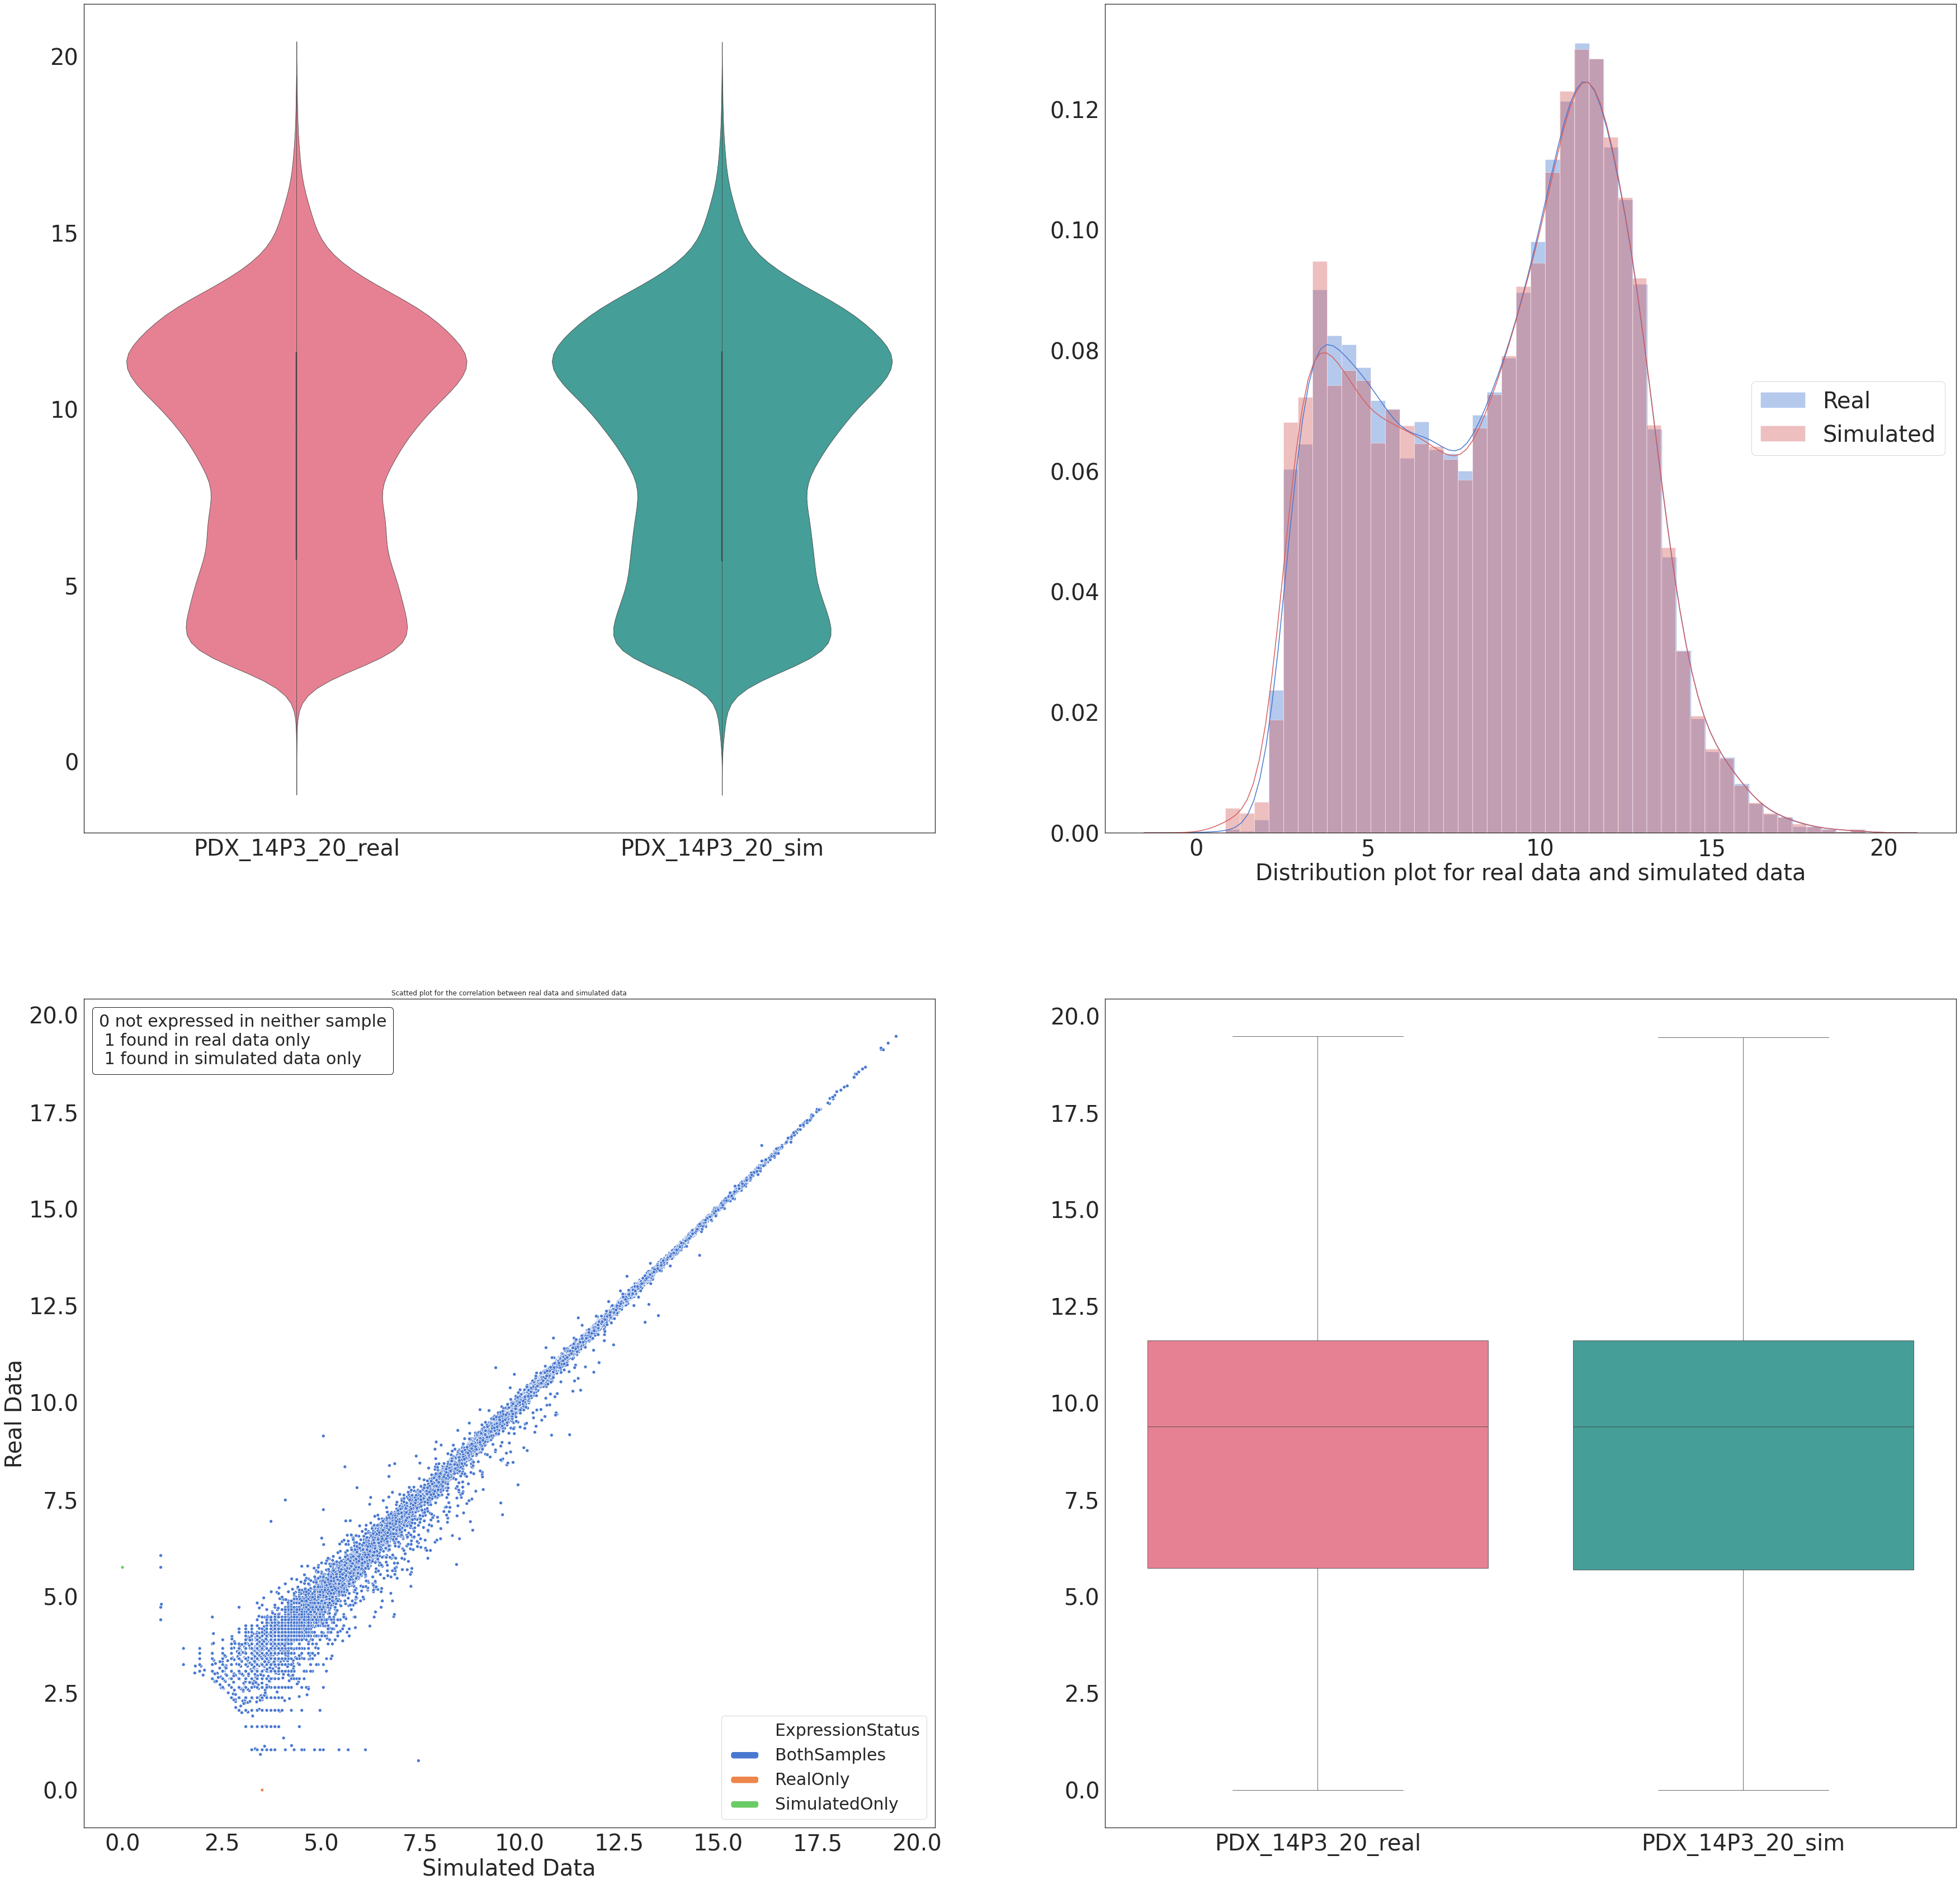

In [63]:
params = {'legend.fontsize': 40,
          'figure.figsize': (60, 60),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'xtick.labelsize': 40,
         'ytick.labelsize': 40}
pylab.rcParams.update(params)
f, axes = plt.subplots(2, 2, figsize = (60, 60))
buildPlotBlock(tenCut, axes)
plt.plot()

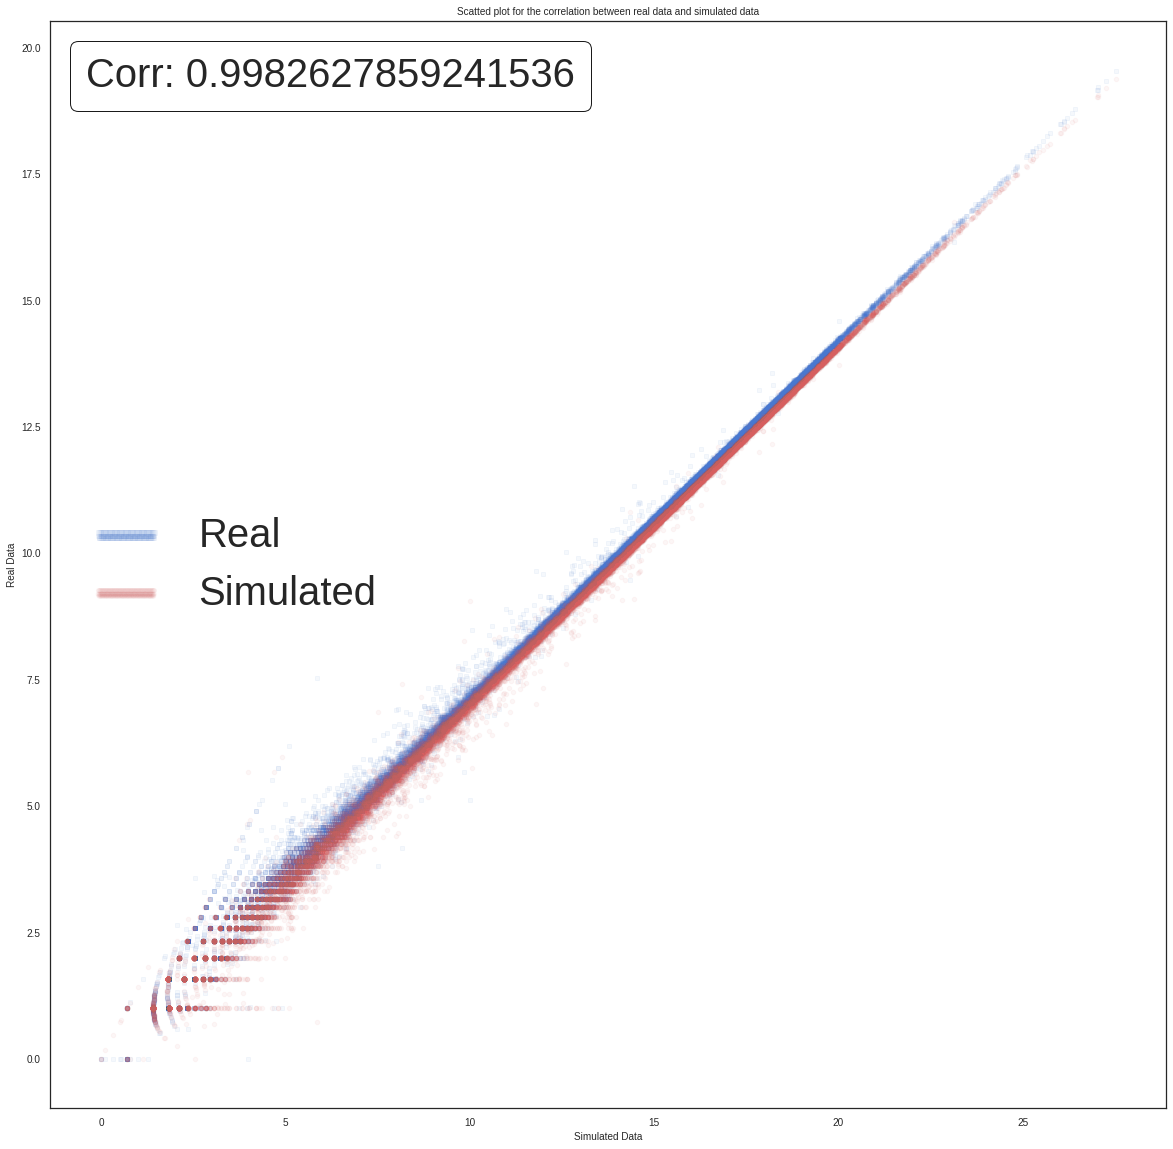

In [68]:
params = {'legend.fontsize': 10,
          'figure.figsize': (20, 20),
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)
f, axes = plt.subplots()
corrScatterPlot(full_data, axes)

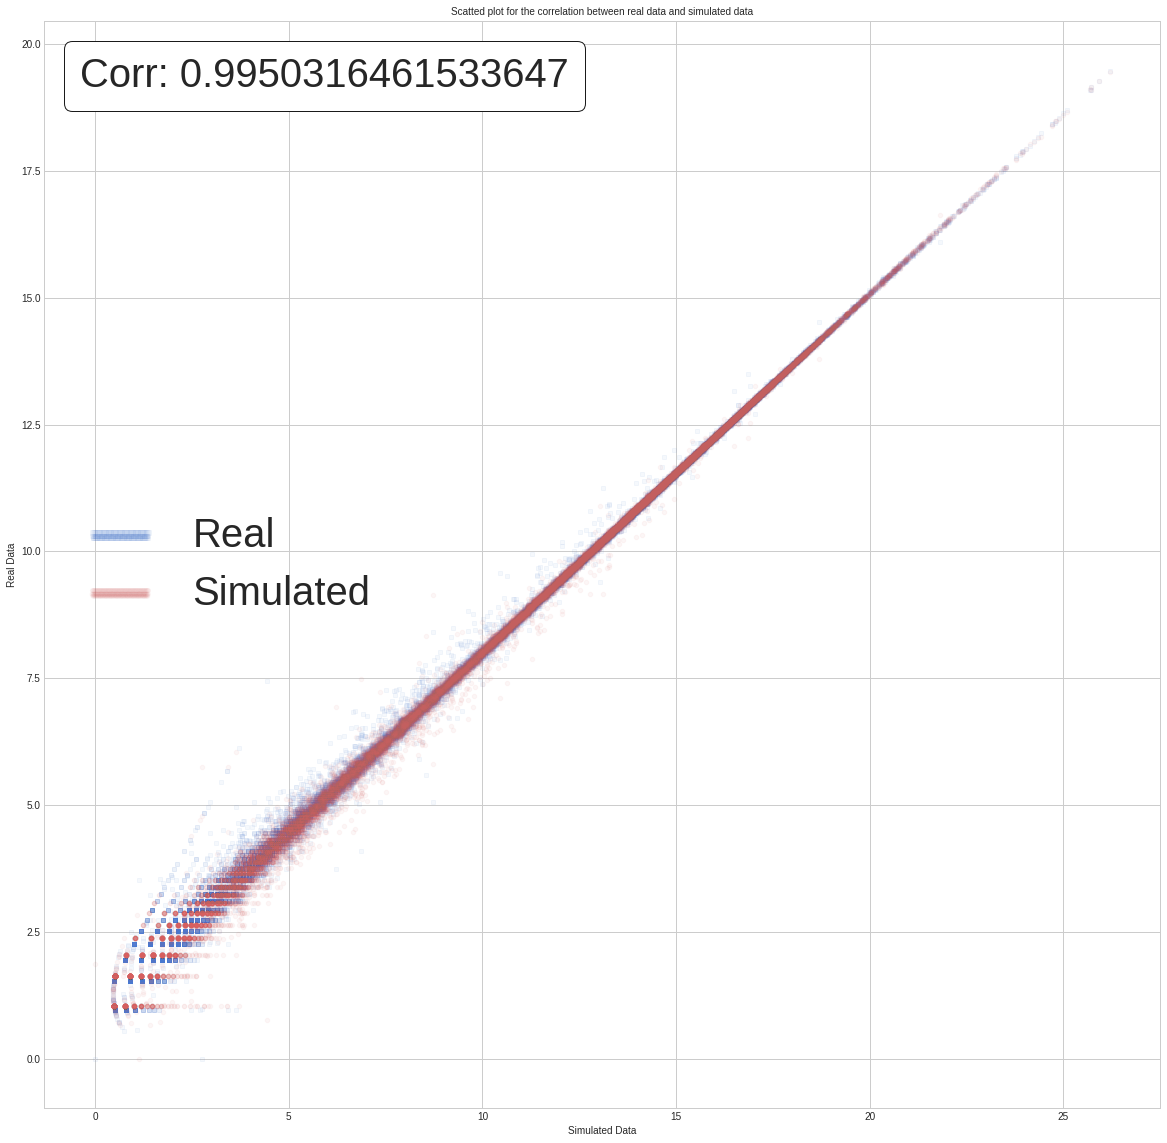

In [69]:
params = {'legend.fontsize': 10,
          'figure.figsize': (20, 20),
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)
f, axes = plt.subplots()
corrScatterPlot(quaterCut, axes)

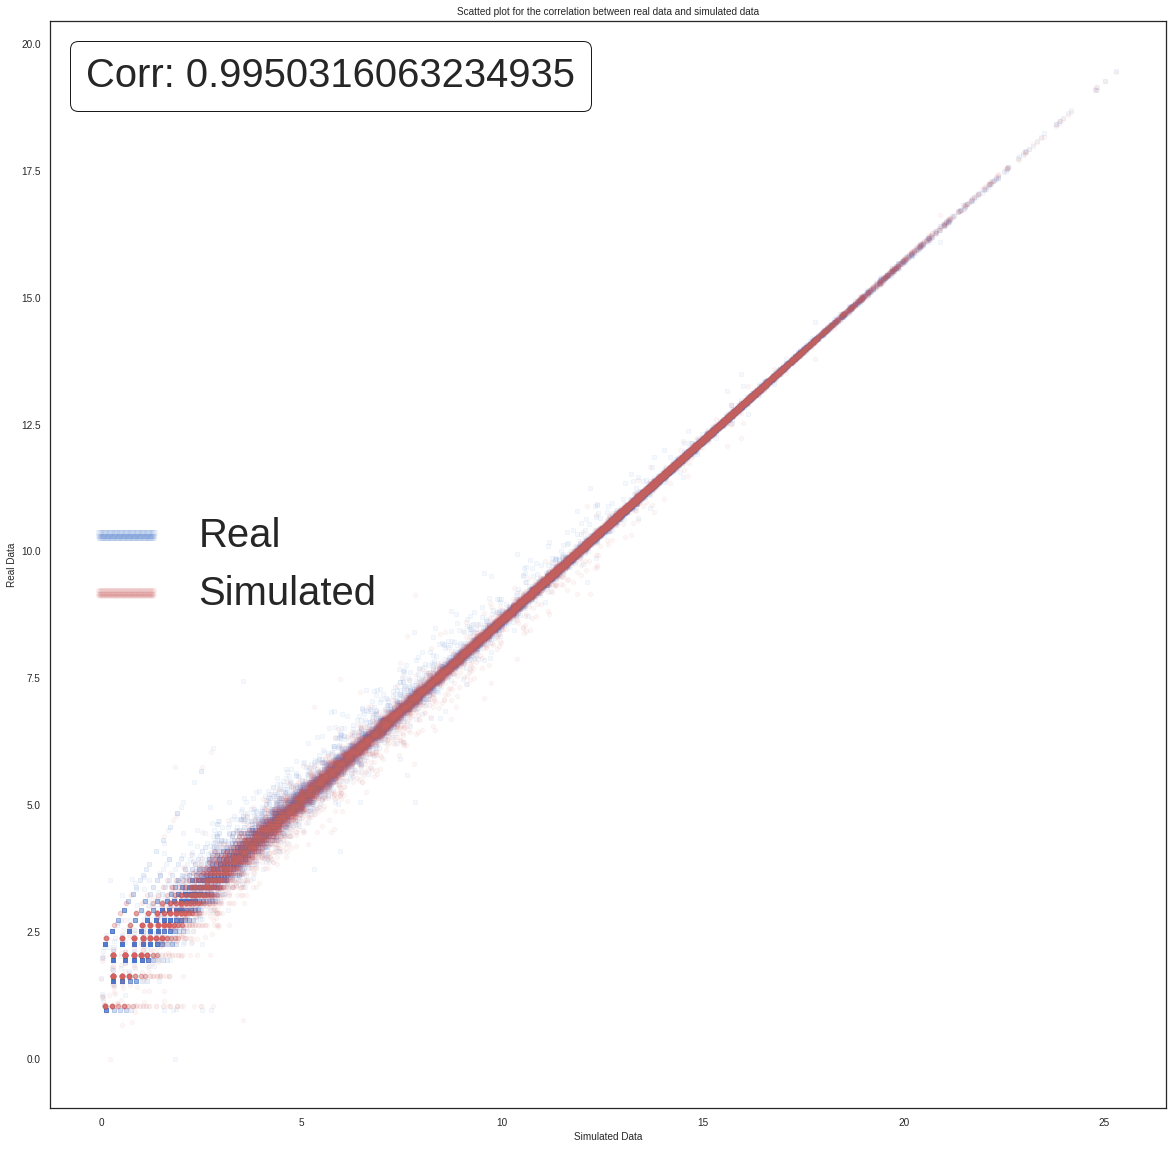

In [72]:
params = {'legend.fontsize': 10,
          'figure.figsize': (20, 20),
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)
f, axes = plt.subplots()
corrScatterPlot(halfCut, axes)

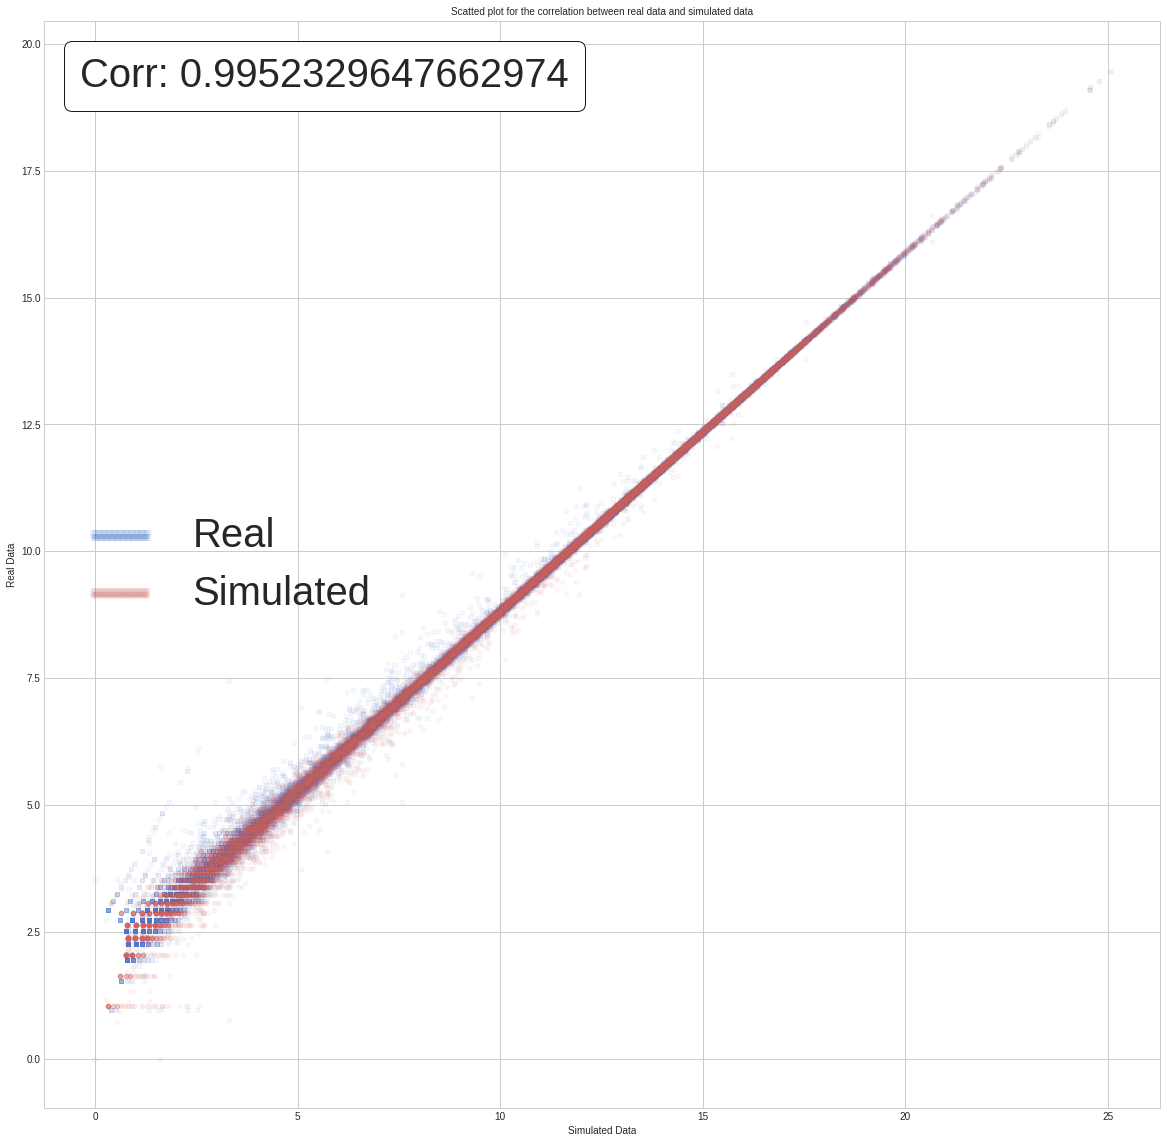

In [73]:
params = {'legend.fontsize': 10,
          'figure.figsize': (20, 20),
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)
f, axes = plt.subplots()
corrScatterPlot(threeQtrCut, axes)

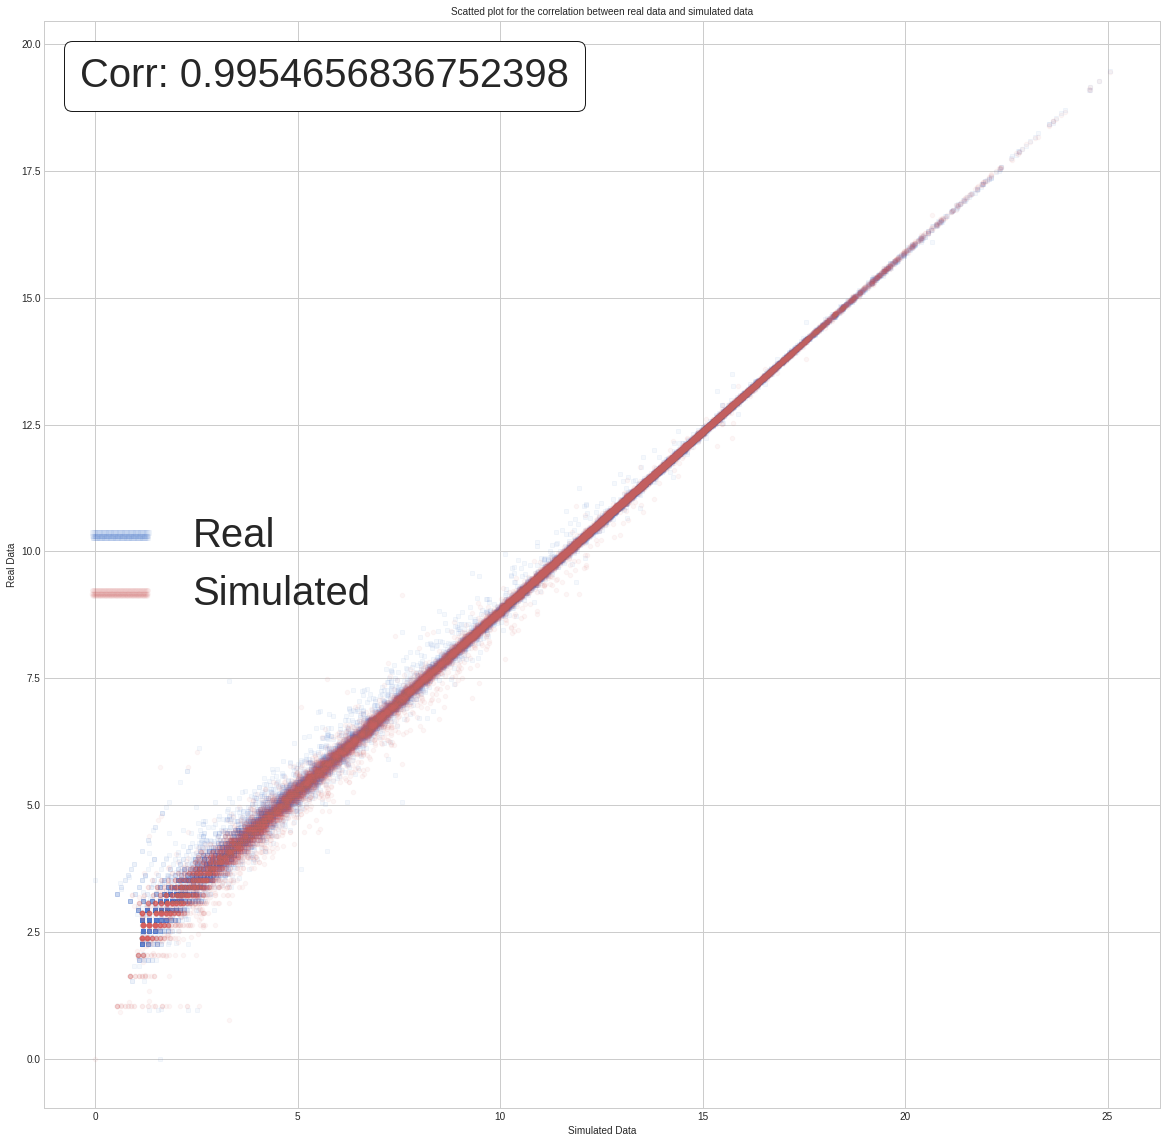

In [74]:
params = {'legend.fontsize': 10,
          'figure.figsize': (20, 20),
         'axes.labelsize': 10,
         'axes.titlesize': 10,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
pylab.rcParams.update(params)
f, axes = plt.subplots()
corrScatterPlot(tenCut, axes)

In [25]:
test = np.log2(full_data[['PDX_14P3_20_real', 'PDX_14P3_20_sim']] + 1)

In [26]:
test

PDX_14P3_20_real  PDX_14P3_20_sim
0             12.298645        12.193090
1              3.906852         3.906929
2             10.735473        10.699634
3              7.583595         7.584401
4              8.519111         8.105403
...                 ...              ...
57768          4.087427         3.584998
57769          5.523560         5.247929
57770          0.999953         1.000047
57771          3.345204         1.855723
57772          0.999941         1.000059

[57773 rows x 2 columns]